# TODO

- Clean up code
  - Function for plotting
  - Better setup for indexing
- Add math 

$$
\begin{bmatrix}
x \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
0 \\
0 \\
y \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
$$


# Load data

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

from iterativennsimple.utils.plot_2D_start_end import plot_2D_start_end

In [2]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [3]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
name = 'MNIST'

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [4]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# Only use the given number of sample
max_num_samples = 1000
num_samples = min(max_num_samples, z_start_tensor.shape[0])
z_start_tensor = z_start_tensor[:num_samples]
z_target_tensor = z_target_tensor[:num_samples]

# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape
x_mask = mask
y_mask = ~mask

# print out the shape of the masks
print(x_mask.shape, y_mask.shape)

# print out number of true entries in each mask
print(x_mask.sum(), y_mask.sum())


torch.Size([794]) torch.Size([794])
tensor(784) tensor(10)


# MLP model

In [5]:
input_size = int(x_mask.sum())
h1_size = 20
h2_size = 20
output_size = int(y_mask.sum())

x_idx = torch.arange(0, input_size)
h_idx = torch.arange(input_size, input_size+h1_size+h2_size)
y_idx = torch.arange(input_size+h1_size+h2_size, input_size+h1_size+h2_size+output_size)

total_size = input_size + h1_size + h2_size + output_size

iterations = 3

I = Identity(in_features=input_size, out_features=input_size)
f1 = Sequential1D(torch.nn.Linear(in_features=input_size, out_features=h1_size), 
                  torch.nn.ReLU(), 
                  in_features=input_size, out_features=h1_size)
f2 = Sequential1D(torch.nn.Linear(in_features=h1_size, out_features=h2_size), 
                  torch.nn.ReLU(), 
                  in_features=h1_size,    out_features=h2_size)
f3 = torch.nn.Linear(in_features=h2_size,    out_features=output_size)    

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

In [6]:
zh_start_tensor = torch.cat((z_start_tensor[:, x_mask],
                             torch.zeros(z_start_tensor.shape[0], len(h_idx)), 
                             z_start_tensor[:, y_mask]), dim=1)
zh_target_tensor = torch.cat((z_target_tensor[:, x_mask], 
                             torch.zeros(z_target_tensor.shape[0], len(h_idx)), 
                             z_target_tensor[:, y_mask]), dim=1)

In [7]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(zh_start_tensor, zh_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [8]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [9]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        mapped = start

        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)

        loss = criterion(mapped[:, y_idx], target[:, y_idx])
        loss.backward()

        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.09078217297792435
Epoch 100, Batch 9, Loss 0.012353384867310524
Epoch 200, Batch 9, Loss 0.006377709563821554
Epoch 300, Batch 9, Loss 0.004184857476502657
Epoch 400, Batch 9, Loss 0.00248505687341094


# Training data

In [14]:
def my_plot(z_start, z_target, z_mapped, plot_points, x_idx, y_idx):
    # Use PCA to reduce the dimensionality of the data
    if len(x_idx) == 1 and len(y_idx) == 1:
        x_idx = x_idx[0]
        start_x = z_start[:, x_idx]
        target_x = z_target[:, x_idx]
        mapped_x = z_mapped[:, x_idx]
        y_idx = y_idx[0]
        start_y = z_start[:, y_idx]
        target_y = z_target[:, y_idx]
        mapped_y = z_mapped[:, y_idx] 
    else:
        # use PCA to reduce the dimensionality of the data
        # using pytorch's PCA implementation
        # https://pytorch.org/docs/stable/generated/torch.pca_lowrank.html
        idx = torch.cat((x_idx, y_idx))
        _, _, V = torch.svd(z_start[:, idx])
        start_x = torch.matmul(z_start[:, idx], V[:, 0])
        target_x = torch.matmul(z_target[:, idx], V[:, 0])
        mapped_x = torch.matmul(z_mapped[:, idx], V[:, 0])
        _, _, V = torch.svd(z_start[:, idx])
        start_y = torch.matmul(z_start[:, idx], V[:, 0])
        target_y = torch.matmul(z_target[:, idx], V[:, 0])
        mapped_y = torch.matmul(z_mapped[:, idx], V[:, 0])

    plot_2D_start_end(start_x, start_y,
                      target_x, target_y, 
                      mapped_x, mapped_y, 
                      plot_points)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

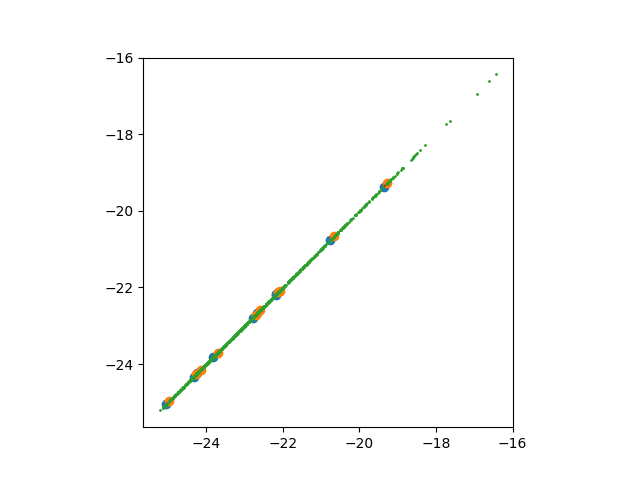

In [15]:
# Hemingway bridge:  This looks strange.  Need to think about how to plot.

plot_iterations = 1

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx)


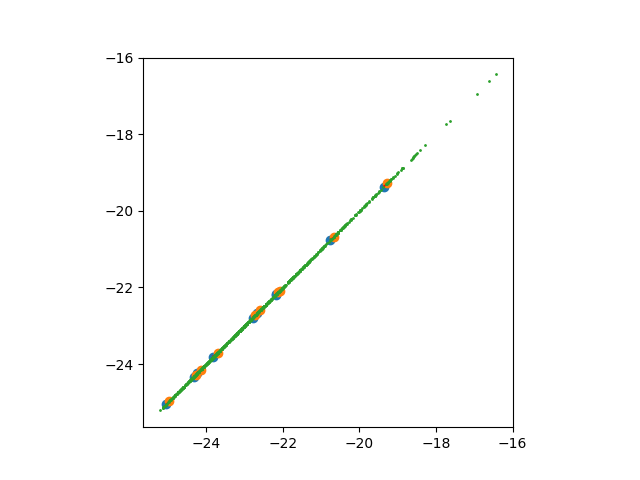

In [16]:
plot_iterations = iterations

mapped_tensor = zh_start_tensor
for i in range(plot_iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx)

# Path

ValueError: x and y must be the same size

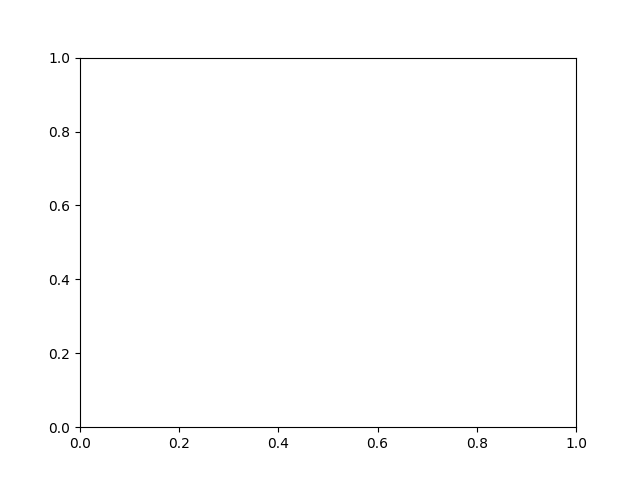

In [17]:
mapped_tensors = [zh_start_tensor]
for i in range(iterations):
    mapped_tensors.append(map(mapped_tensors[i]).detach())

plot_points = 10

plt.figure()

plt.scatter(zh_target_tensor[:, x_idx], zh_target_tensor[:, y_idx], s=1)
for i, mapped_tensor in enumerate(mapped_tensors):
    if i > 0:
        start = mapped_tensors[i-1]
        target = mapped_tensors[i]
        dx = target[:plot_points, x_idx]-start[:plot_points, x_idx]
        dy = target[:plot_points, y_idx]-start[:plot_points, y_idx]
        plt.quiver(start[:plot_points, x_idx], start[:plot_points, y_idx], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.gca().set_aspect('equal')
plt.show()

# Testing data

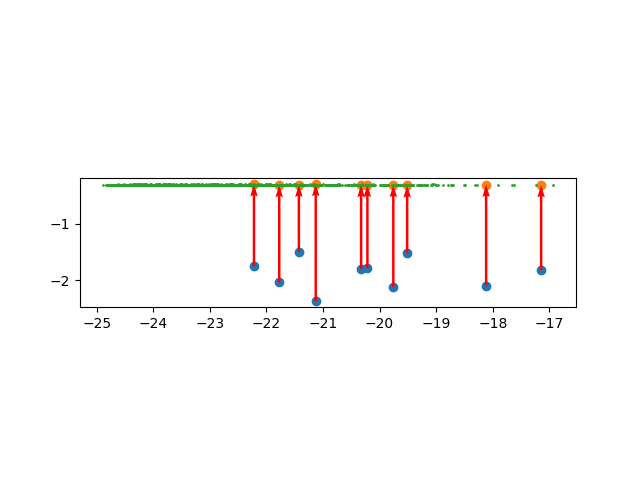

In [ ]:
zh_start_tensor_test = zh_start_tensor+torch.rand_like(zh_start_tensor)*0.2
mapped_tensor = zh_start_tensor_test
for i in range(iterations):
    mapped_tensor = map(mapped_tensor)
mapped_tensor = mapped_tensor.detach()

my_plot(zh_start_tensor_test, mapped_tensor, zh_target_tensor, plot_points=10, x_idx=x_idx, y_idx=y_idx)
